In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly
#import plotly.graph_objs as go
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.tools import diff
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install openpyxl

oil_pp=pd.read_excel("US Crude Oil Data.xlsx")
oil_pp

,Date,Price
0,1974-01-15,6.95
1,1974-02-15,6.87
2,1974-03-15,6.77
3,1974-04-15,6.77
4,1974-05-15,6.87
...,...,...
591,2023-04-15,77.22
592,2023-05-15,70.14
593,2023-06-15,68.58
594,2023-07-15,74.05


In [3]:
oil_pp.shape

(596, 2)

In [4]:
oil_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    596 non-null    datetime64[ns]
 1   Price   596 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 9.4 KB


In [5]:
oil_pp.isnull().sum()

Date     0
Price    0
dtype: int64

In [6]:
oil_pp[oil_pp.duplicated()]

,Date,Price


In [7]:
oil_pp.describe()

,Price
count,596.000000
mean,36.827483
std,28.567558
min,6.700000
25%,14.995000
50%,25.855000
75%,55.057500
max,128.080000


### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [8]:
oil_pp["Date"]  = pd.to_datetime(oil_pp.Date, format="%b-%y")
oil_pp["month"] = oil_pp.Date.dt.strftime("%b") # month extraction
oil_pp["year"]  = oil_pp.Date.dt.strftime("%Y") # year extraction
oil_pp.head(10)

,Date,Price,month,year
0,1974-01-15,6.95,Jan,1974
1,1974-02-15,6.87,Feb,1974
2,1974-03-15,6.77,Mar,1974
3,1974-04-15,6.77,Apr,1974
4,1974-05-15,6.87,May,1974
5,1974-06-15,6.85,Jun,1974
6,1974-07-15,6.80,Jul,1974
7,1974-08-15,6.71,Aug,1974
8,1974-09-15,6.70,Sep,1974
9,1974-10-15,6.97,Oct,1974


# Data Visualization

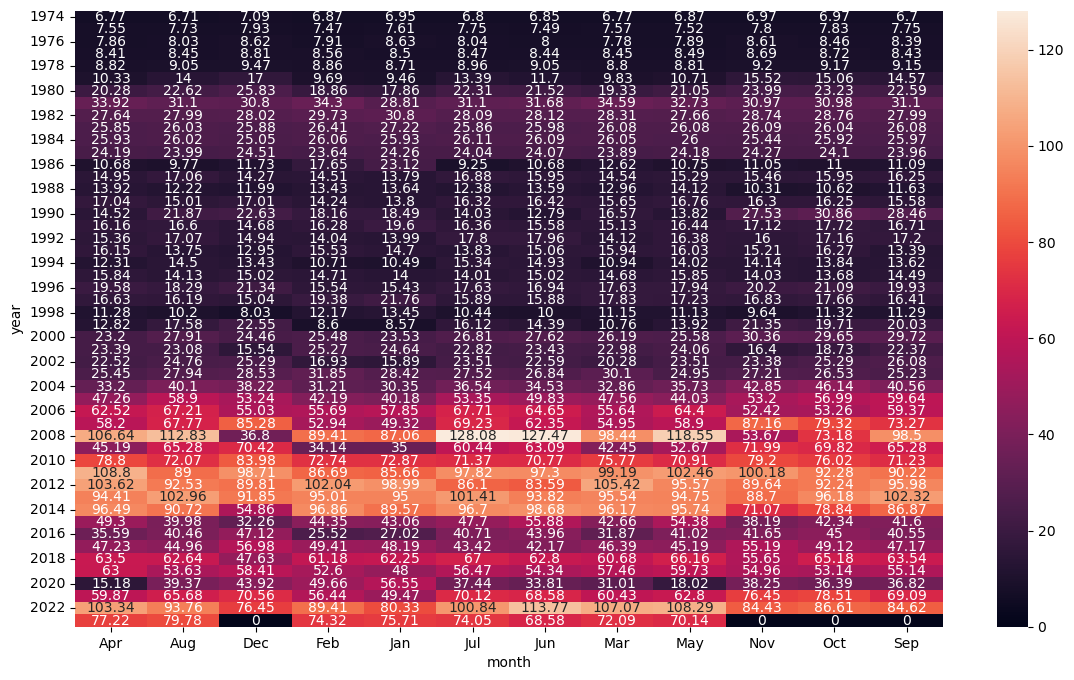

In [9]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=oil_pp,values="Price",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g") #fmt is format of the grid values
plt.show()

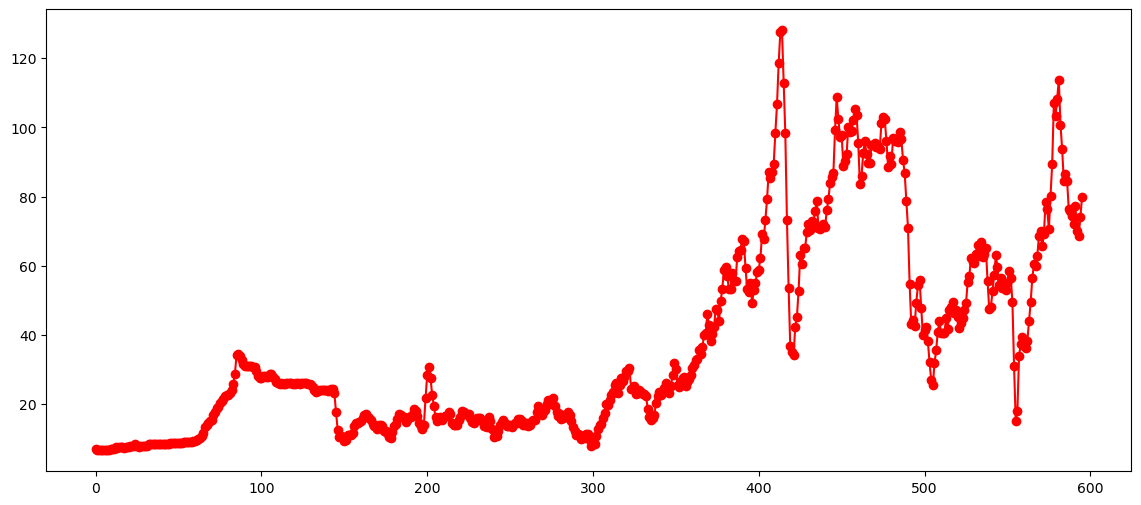

In [10]:
oil_pp['Price'].plot(figsize=(14,6),color='red',marker='o')
plt.show()

## Observation :
### We can see that there is an increasing Trend but downwards at times. So, Trend is not constant.
### Variance is also not constant.
### Hence the time serise is not stationary.

# Yearly Price Analysis

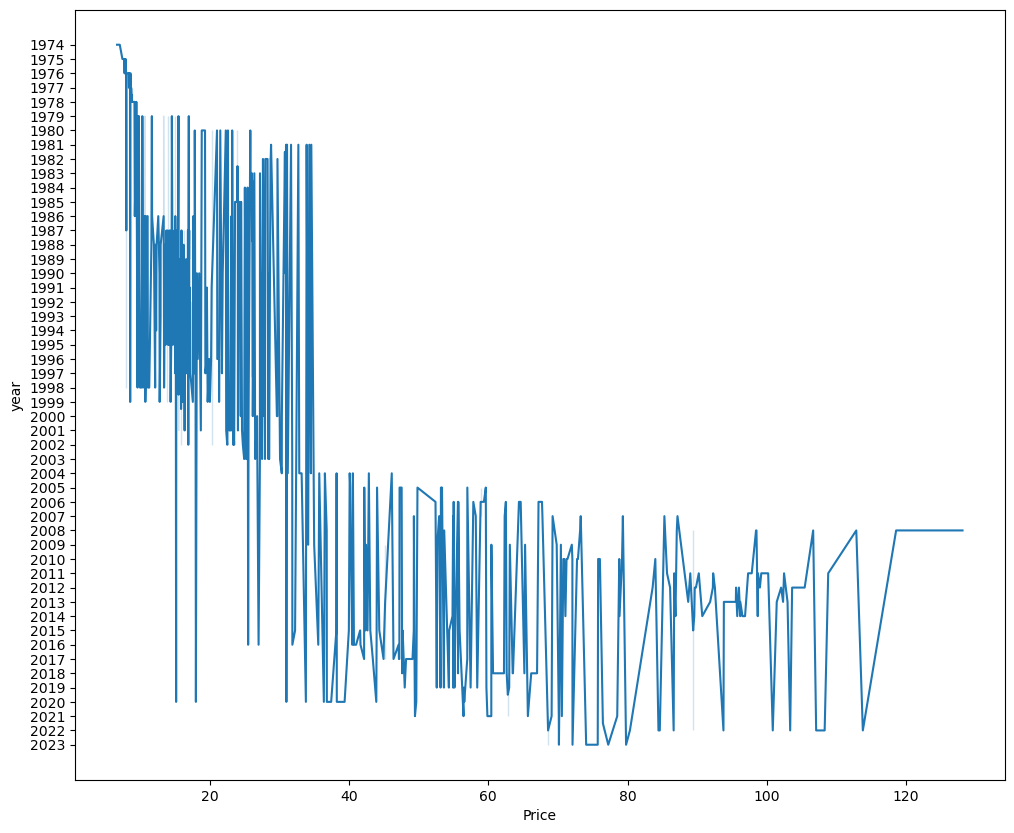

In [11]:
plt.figure(figsize=(12,10))
sns.lineplot(x="Price", y="year", data=oil_pp)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

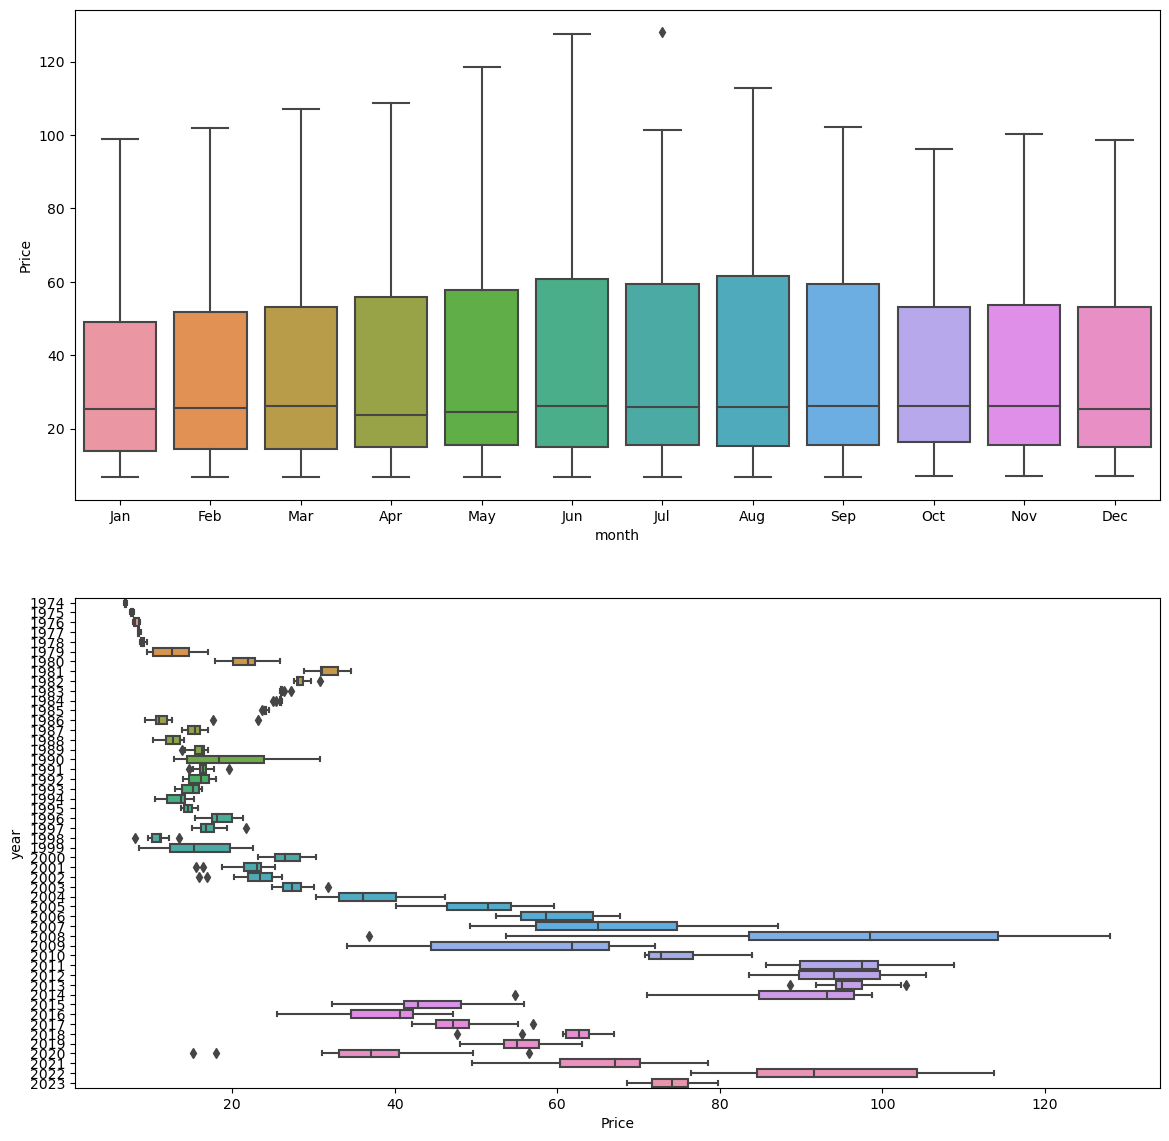

In [12]:
plt.figure(figsize=(14,14))
plt.subplot(211)
sns.boxplot(x="month", y="Price", data=oil_pp)
plt.subplot(212)
sns.boxplot(x="Price", y="year", data=oil_pp)
plt.show()

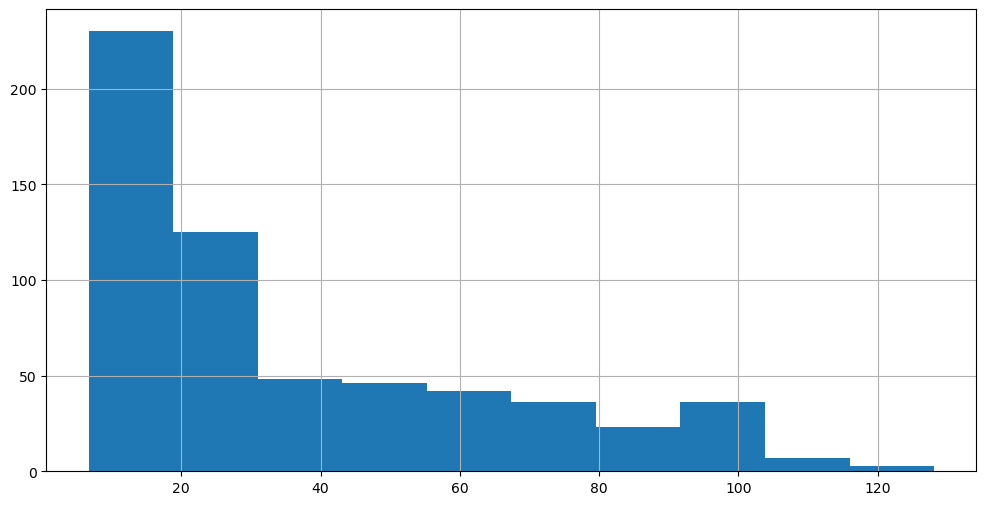

In [13]:
oil_pp.Price.hist(figsize=(12,6))
plt.show()

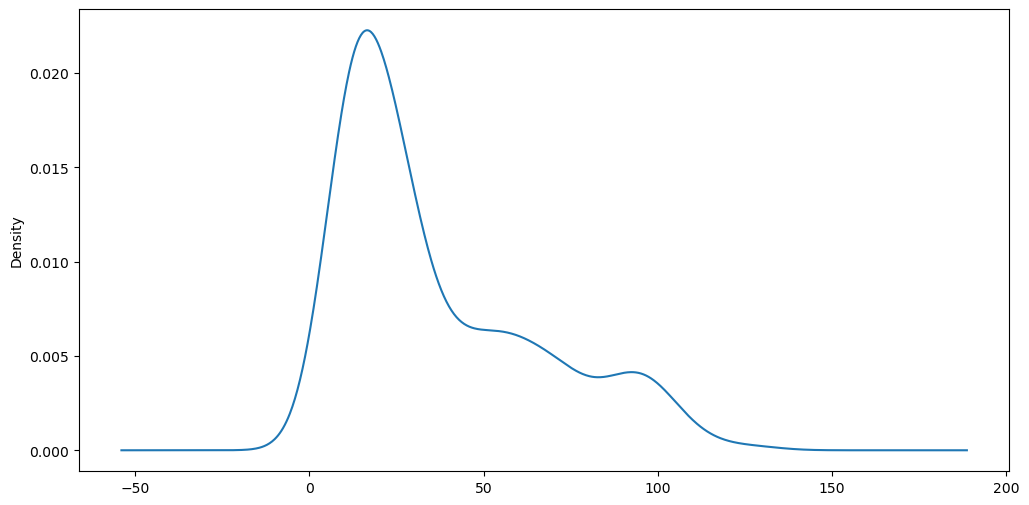

In [14]:
oil_pp.Price.plot(kind='kde', figsize=(12,6))
plt.show()

## Moving Average

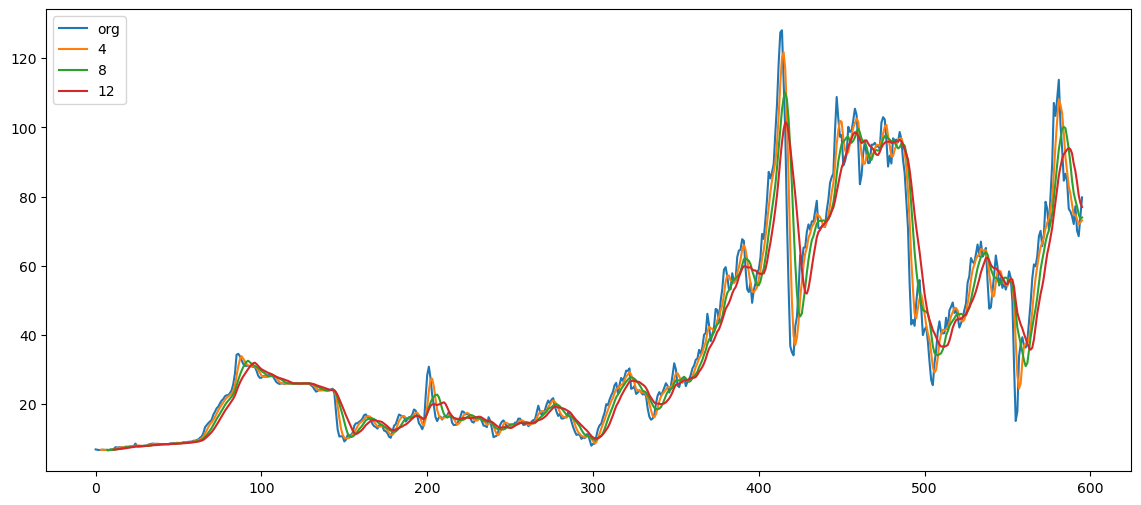

In [15]:
plt.figure(figsize=(14,6))
oil_pp.Price.plot(label="org")
for i in range(4,13,4):
    oil_pp["Price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.show()

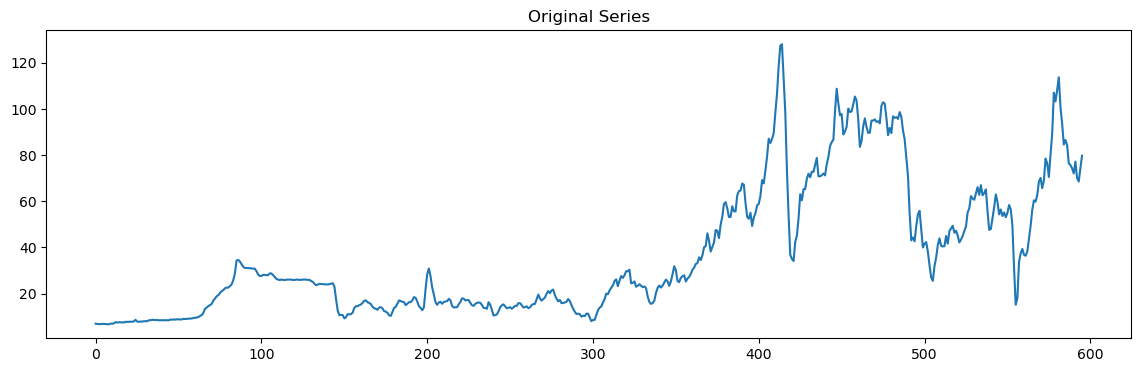

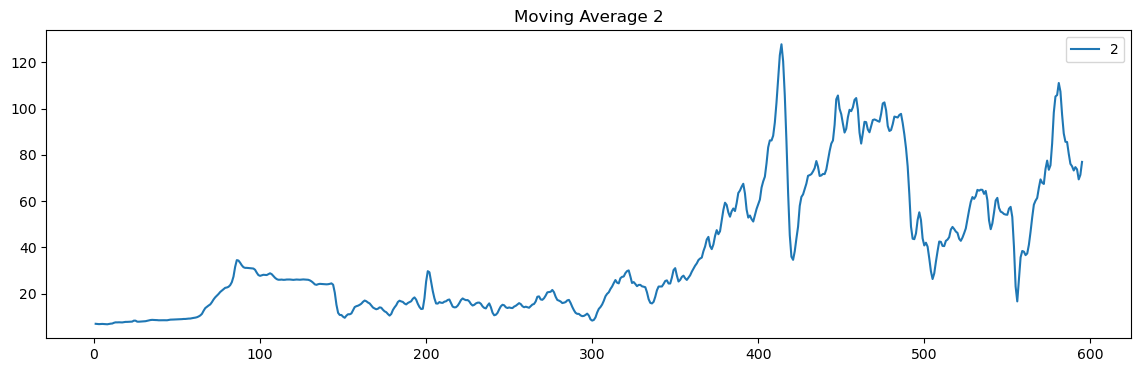

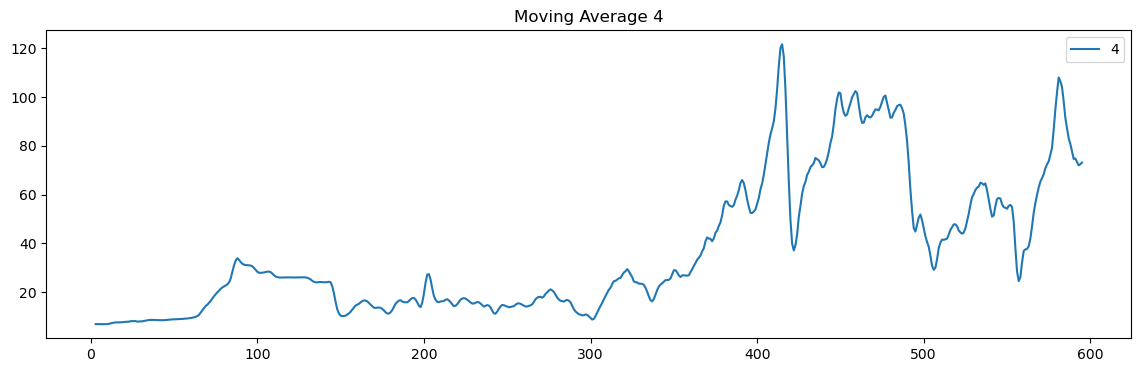

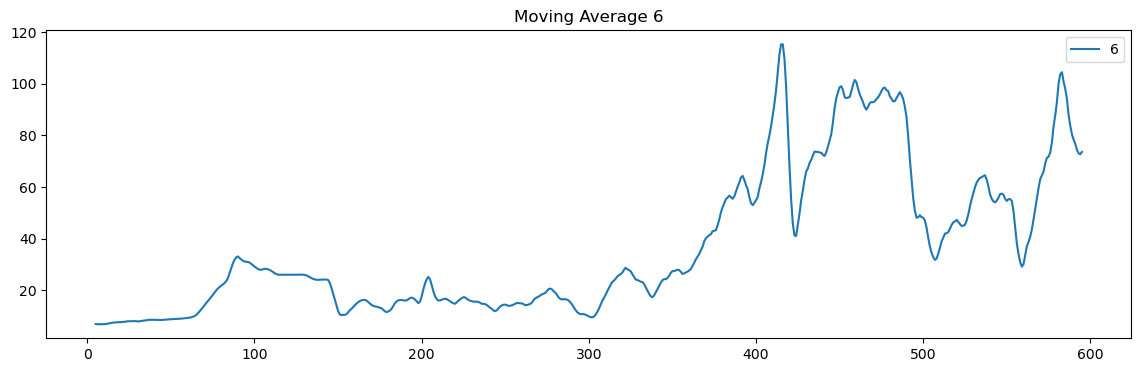

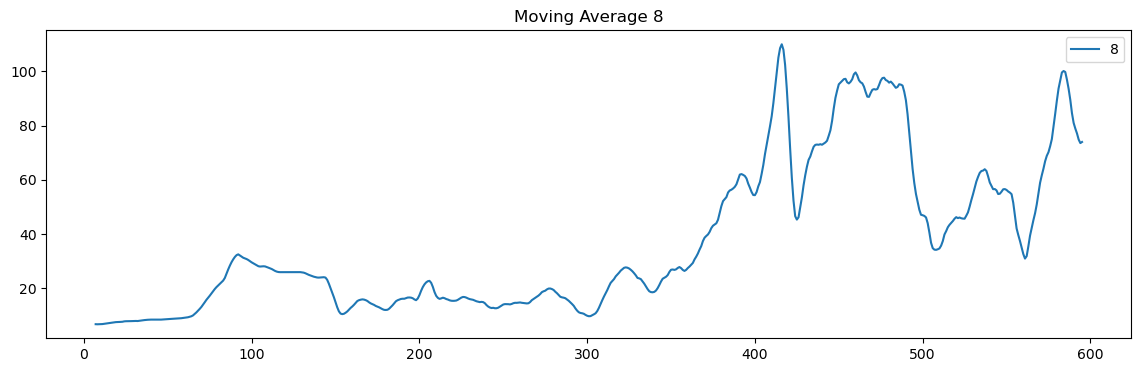

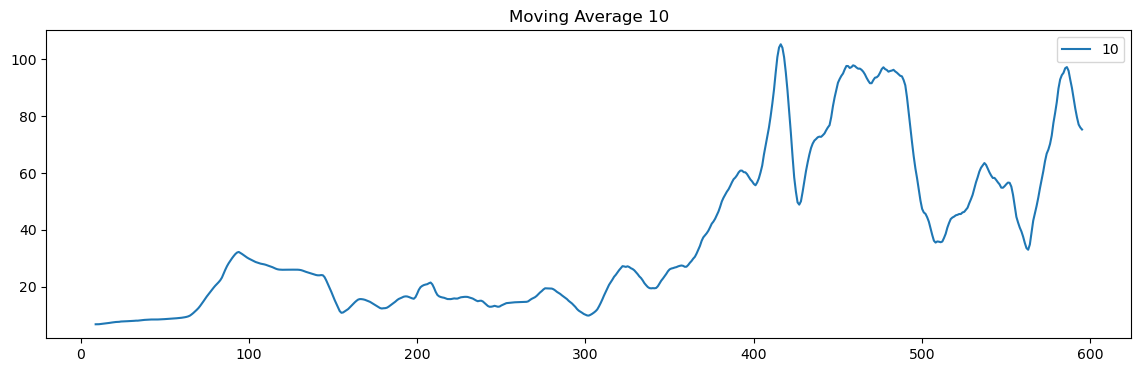

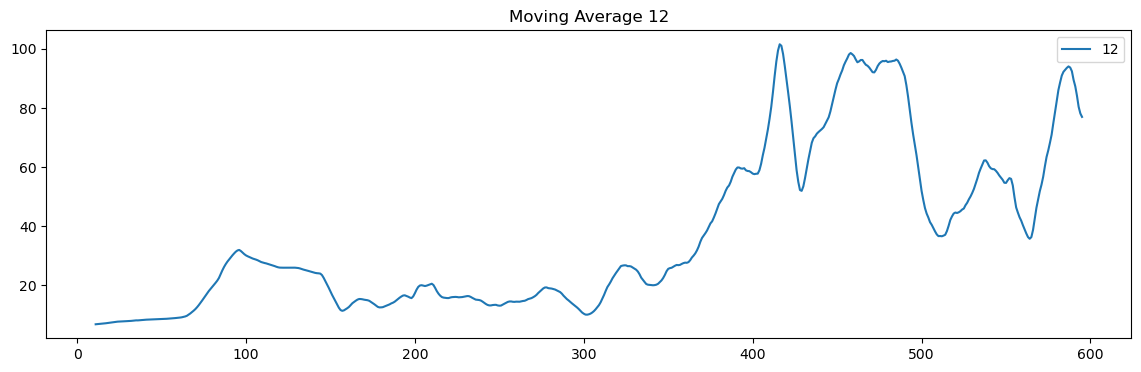

In [16]:
plt.figure(figsize=(14,4))
oil_pp.Price.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(14,4))
    oil_pp["Price"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

## Time series decomposition plot

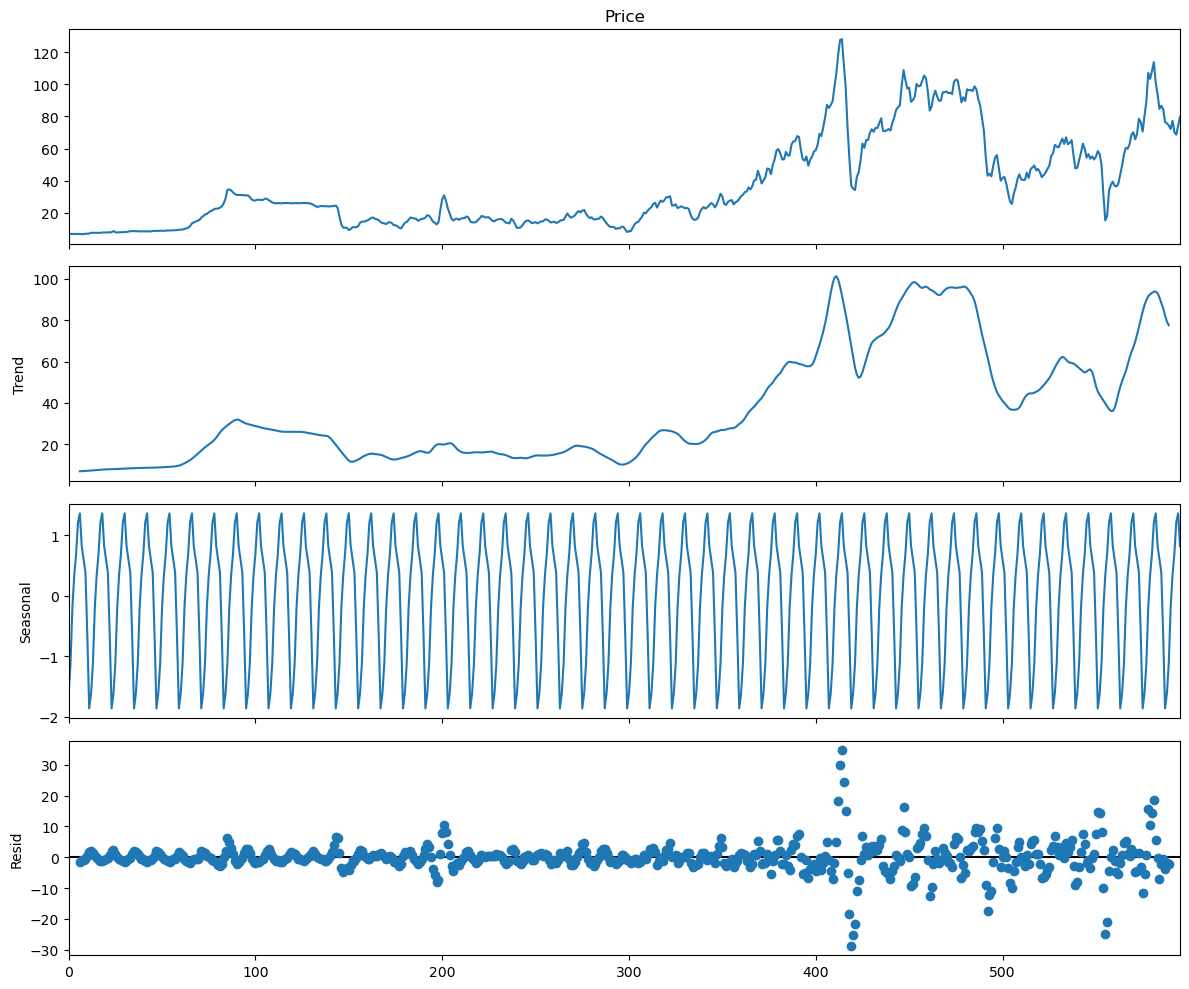

In [17]:
decompose_ts_add = seasonal_decompose(oil_pp.Price, period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

# ACF plots and PACF plots

## Autocorrelation Function (ACF)

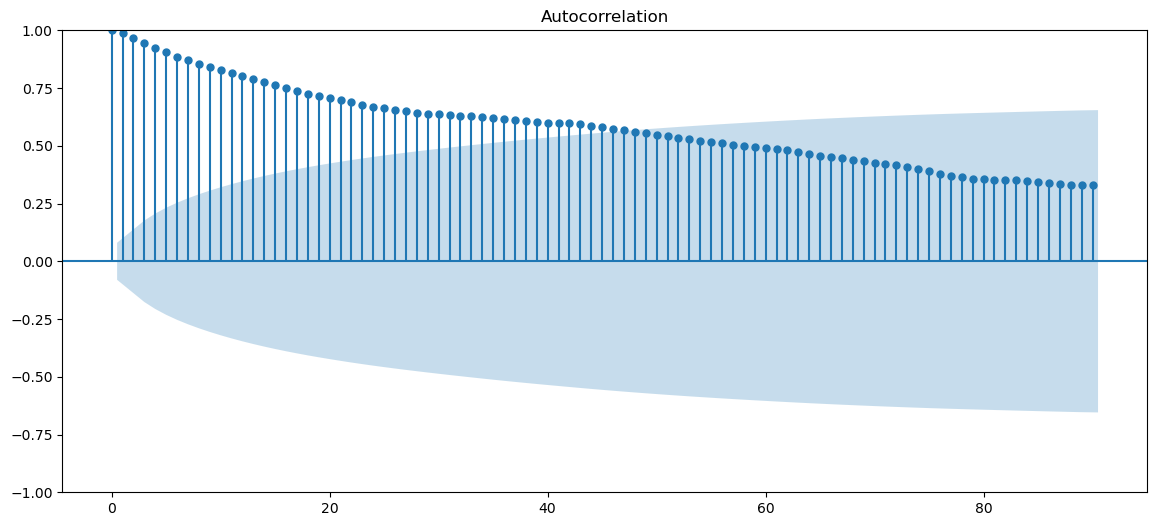

In [18]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(oil_pp.Price, lags=90)
    plt.show()

## Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

## Partial Autocorrelation Function (PACF)

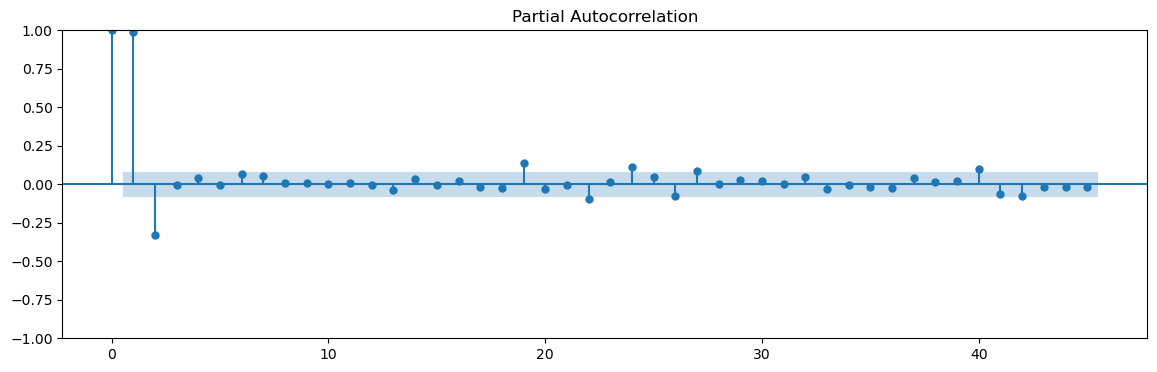

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_pacf(oil_pp.Price,lags=45)
    plt.show()

## A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

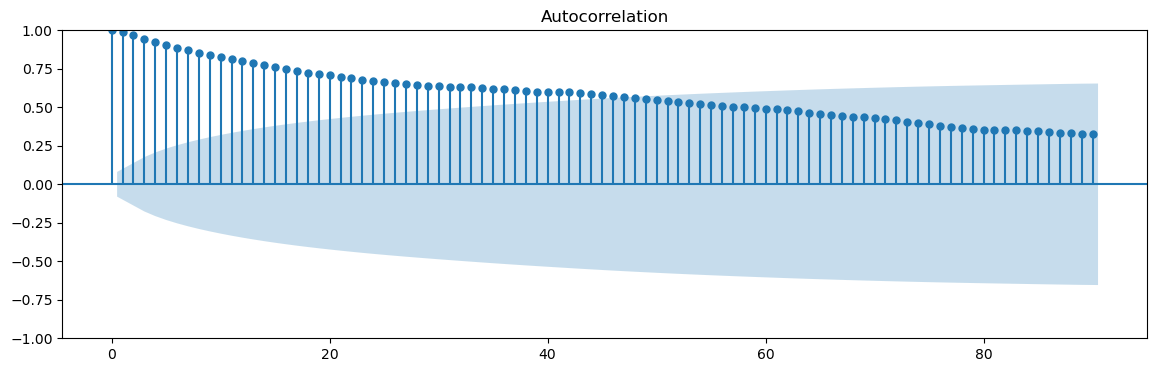

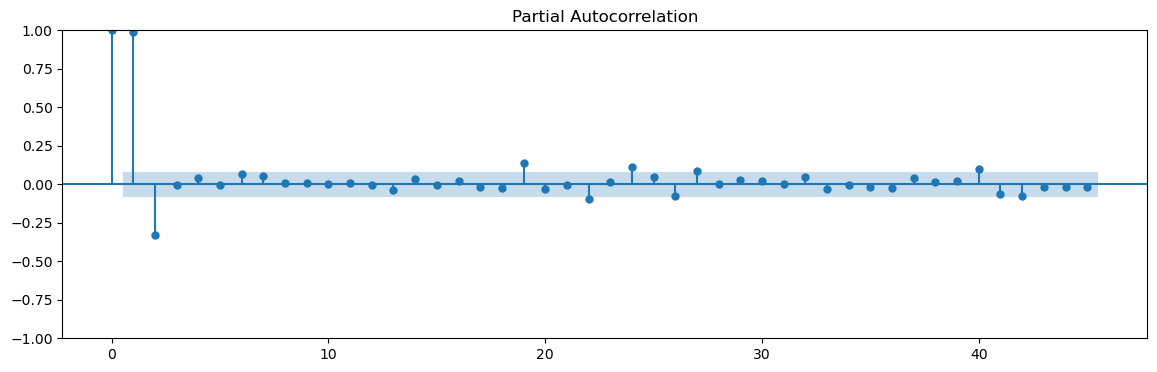

In [20]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,4))
    tsa_plots.plot_acf(oil_pp.Price,lags=90)
    tsa_plots.plot_pacf(oil_pp.Price,lags=45)
    plt.show()

# Time Series Decomposition
### 1. Seasonality
### 2. Trend
## Additive Seasonal Decomposition

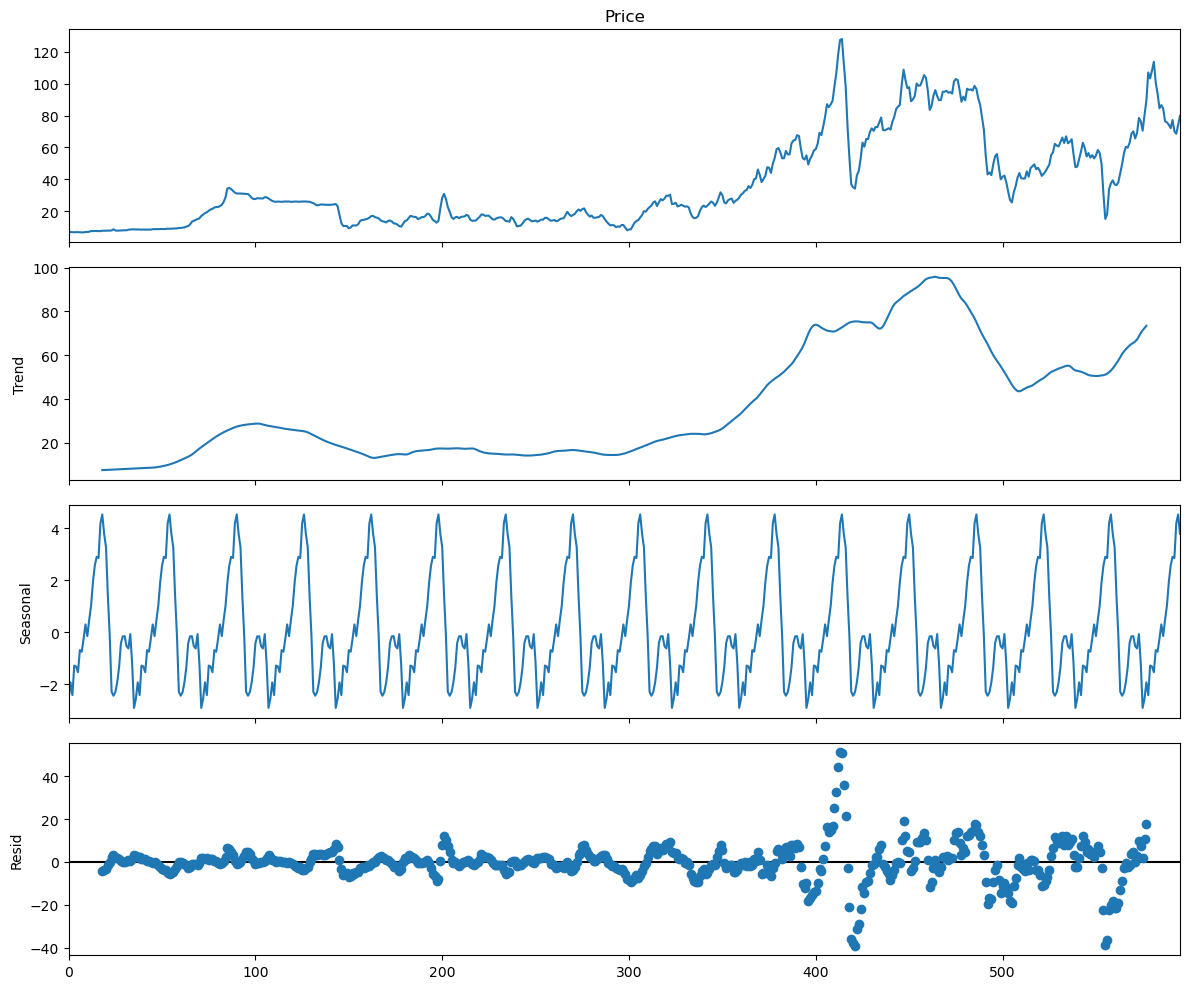

In [21]:
decompose_ts_add = seasonal_decompose(oil_pp.Price, period=36, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

## Observation:-
### Observed - Actual data
### Trend - Increasing or decreasing trend.
### Seasonal -
### Varies from +4 to -4 with the mean 0.
### Residual - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

# Multiplicative Seasonal Decomposition

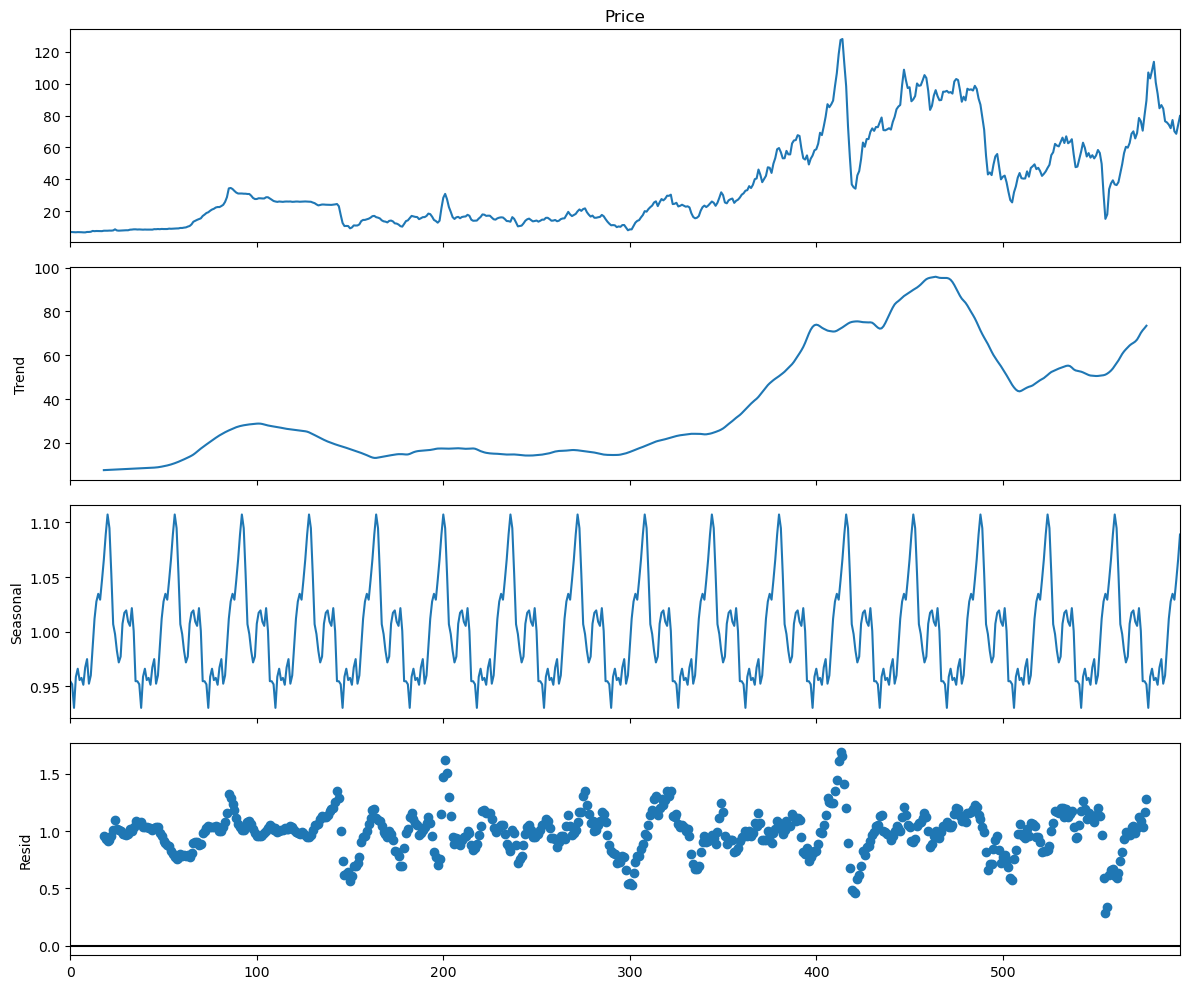

In [22]:
decompose_ts_add = seasonal_decompose(oil_pp.Price, period=36, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

## Observation:-
### Seasonal -
### Varies from 0.90 to 1.10
### The value in the Y-axis has to be multiplied to the Trend plot value to get the actual value.

# Holt-Winters Method for Forecasting

In [23]:
train_hw = oil_pp.iloc[0:478]
test_hw = oil_pp.iloc[478:]

##### Creating DataFrame for storing results from holt-winters method

In [24]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
!pip install statsmodels

hw_model_results = test_hw


In [25]:
def simple_expo(span, time_series):
    alpha = 2/(span + 1)
    return SimpleExpSmoothing(time_series).fit(smoothing_level=alpha,optimized=False)

In [26]:
model_s5month_exp = simple_expo(5, train_hw['Price'])

In [27]:
hw_model_results['SES5'] = model_s5month_exp.forecast(30)
hw_model_results['SES5'].dropna()


478    98.670492
479    98.670492
480    98.670492
481    98.670492
482    98.670492
483    98.670492
484    98.670492
485    98.670492
486    98.670492
487    98.670492
488    98.670492
489    98.670492
490    98.670492
491    98.670492
492    98.670492
493    98.670492
494    98.670492
495    98.670492
496    98.670492
497    98.670492
498    98.670492
499    98.670492
500    98.670492
501    98.670492
502    98.670492
503    98.670492
504    98.670492
505    98.670492
506    98.670492
507    98.670492
Name: SES5, dtype: float64

In [28]:
model_s25month_exp = simple_expo(25, train_hw['Price'])

In [29]:
hw_model_results['SES25'] = model_s25month_exp.forecast(30)

### Using Double exponential smoothing as it also incorporates the trend component

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_des_mul = ExponentialSmoothing(train_hw['Price'], trend='mul').fit()

In [31]:
hw_model_results['DESMul'] = model_des_mul.forecast(30)

In [32]:
model_des_add = ExponentialSmoothing(train_hw['Price'], trend='add').fit()
hw_model_results['DESadd'] = model_des_mul.forecast(30)

Now Using triple exponential smoothing which takes into account both trend and seasonality

In [33]:
model_tes_add = ExponentialSmoothing(train_hw['Price'],trend='add',seasonal='add',seasonal_periods=238).fit()

In [34]:
hw_model_results['TESadd'] = model_tes_add.forecast(30)

In [35]:
model_tes_mul = ExponentialSmoothing(train_hw['Price'],trend='mul',seasonal='mul',seasonal_periods=238).fit()
hw_model_results['TESmul'] = model_tes_add.forecast(30)

In [36]:
hw_model_results.head()

,Date,Price,month,year,SES5,SES25,DESMul,DESadd,TESadd,TESmul
478,2013-11-15,88.70,Nov,2013,98.670492,94.629017,92.339972,92.339972,94.868044,94.868044
479,2013-12-15,91.85,Dec,2013,98.670492,94.629017,88.653259,88.653259,94.945842,94.945842
480,2014-01-15,89.57,Jan,2014,98.670492,94.629017,85.113740,85.113740,95.080367,95.080367
481,2014-02-15,96.86,Feb,2014,98.670492,94.629017,81.715538,81.715538,95.723617,95.723617
482,2014-03-15,96.17,Mar,2014,98.670492,94.629017,78.453010,78.453010,96.525315,96.525315


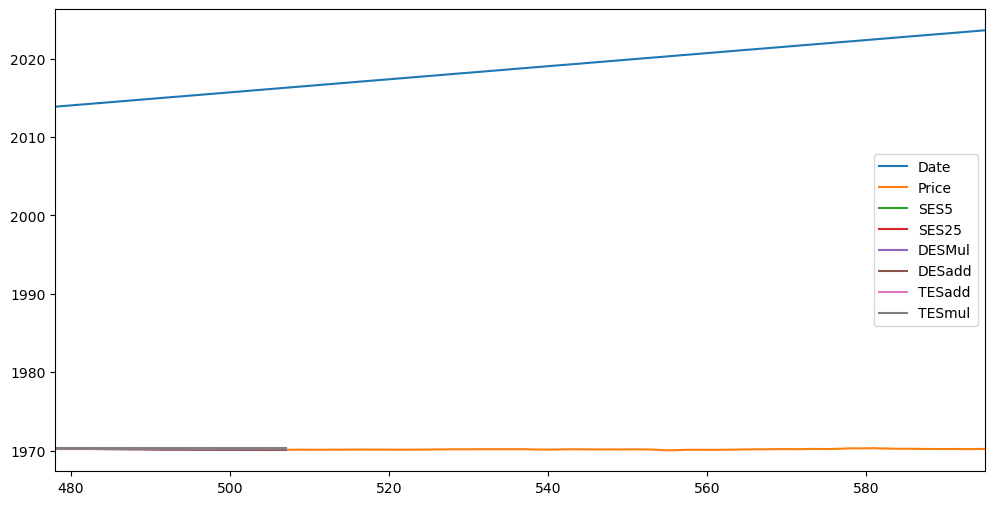

In [37]:
hw_model_results.plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [38]:
hw_model_results.isnull()

,Date,Price,month,year,SES5,SES25,DESMul,DESadd,TESadd,TESmul
478,False,False,False,False,False,False,False,False,False,False
479,False,False,False,False,False,False,False,False,False,False
480,False,False,False,False,False,False,False,False,False,False
481,False,False,False,False,False,False,False,False,False,False
482,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
591,False,False,False,False,True,True,True,True,True,True
592,False,False,False,False,True,True,True,True,True,True
593,False,False,False,False,True,True,True,True,True,True
594,False,False,False,False,True,True,True,True,True,True


In [39]:
hw_model_results.dropna()

,Date,Price,month,year,SES5,SES25,DESMul,DESadd,TESadd,TESmul
478,2013-11-15,88.70,Nov,2013,98.670492,94.629017,92.339972,92.339972,94.868044,94.868044
479,2013-12-15,91.85,Dec,2013,98.670492,94.629017,88.653259,88.653259,94.945842,94.945842
480,2014-01-15,89.57,Jan,2014,98.670492,94.629017,85.113740,85.113740,95.080367,95.080367
481,2014-02-15,96.86,Feb,2014,98.670492,94.629017,81.715538,81.715538,95.723617,95.723617
482,2014-03-15,96.17,Mar,2014,98.670492,94.629017,78.453010,78.453010,96.525315,96.525315
483,2014-04-15,96.49,Apr,2014,98.670492,94.629017,75.320740,75.320740,96.906482,96.906482
484,2014-05-15,95.74,May,2014,98.670492,94.629017,72.313527,72.313527,97.074645,97.074645
485,2014-06-15,98.68,Jun,2014,98.670492,94.629017,69.426379,69.426379,96.759367,96.759367
486,2014-07-15,96.70,Jul,2014,98.670492,94.629017,66.654501,66.654501,96.291432,96.291432
487,2014-08-15,90.72,Aug,2014,98.670492,94.629017,63.993291,63.993291,96.427528,96.427528


In [40]:
def eval_matrix(actual, forecast):
    mean_error = mean_squared_error(actual, forecast)
    root_mean_error = np.sqrt(mean_error)
    return [mean_error, root_mean_error]

In [41]:
hw_model_results = hw_model_results.dropna()


In [42]:
hw_model_results = hw_model_results.fillna(0)


In [43]:
simple_exp5_result = eval_matrix(hw_model_results['Price'], hw_model_results['SES5'])
simple_exp25_result = eval_matrix(hw_model_results['Price'], hw_model_results['SES25'])
double_exp_result = eval_matrix(hw_model_results['Price'], hw_model_results['DESMul'])


In [44]:
simple_exp5_result  = eval_matrix(hw_model_results['Price'], hw_model_results['SES5'])
simple_exp25_result = eval_matrix(hw_model_results['Price'], hw_model_results['SES25'])
double_exp_result   = eval_matrix(hw_model_results['Price'], hw_model_results['DESMul'])
triple_exp_result   = eval_matrix(hw_model_results['Price'], hw_model_results['TESmul'])

In [45]:
simple_exp5_result

[1947.0037999263304, 44.124866004627485]

In [46]:
simple_exp25_result

[1673.6188681215383, 40.909887168281685]

In [47]:
double_exp_result

[198.7933115359713, 14.099408198075949]

In [48]:
triple_exp_result

[1852.2875906489703, 43.038210820722675]

In [49]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'oil_pp' is your DataFrame and 'your_column_name' is the column you want to model
oil_pp['Price'] = pd.to_numeric(oil_pp['Price'], errors='coerce')
oil_pp = oil_pp.dropna()  # or oil_pp = oil_pp.fillna(some_value)

# Fit the ARIMA model
model = sm.tsa.ARIMA(oil_pp['Price'], order=(2, 1, 2))
results = model.fit()

# Access the results and summary
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  596
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1570.917
Date:                Sat, 02 Dec 2023   AIC                           3151.835
Time:                        13:39:31   BIC                           3173.778
Sample:                             0   HQIC                          3160.380
                                - 596                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3801      0.041     33.681      0.000       1.300       1.460
ar.L2         -0.4772      0.043    -11.061      0.000      -0.562      -0.393
ma.L1         -0.9211      0.053    -17.357      0.0

## MODEL EVALUATION OF ARIMA

In [56]:


# Get the predicted values
predicted_values = model.fit().fittedvalues

# Get the actual values
actual_values = oil_pp['Price']

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

# Access the ARIMA model summary
#print(results.summary())


Root Mean Squared Error (RMSE): 3.3994321735418396
Mean Absolute Error (MAE): 2.102808918817223


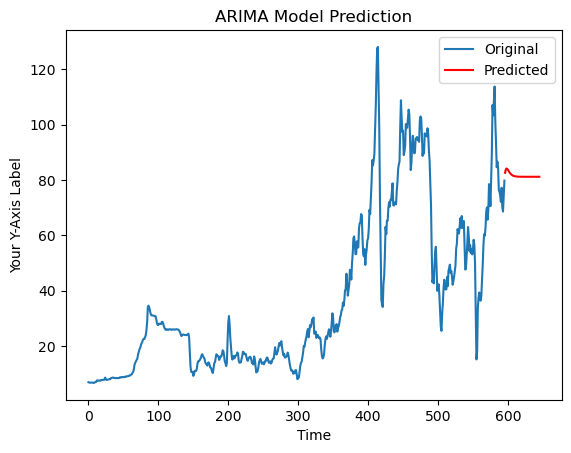

In [57]:

# Get forecast values and confidence intervals
forecast = results.get_forecast(steps=50)

# Plot the original time series
plt.plot(oil_pp['Price'], label='Original')

# Plot the predicted values
plt.plot(forecast.predicted_mean, label='Predicted', color='red')

# Plot confidence intervals if needed
#plt.fill_between(forecast.conf_int()['lower'], forecast.conf_int()['upper'], color='pink', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Time')
plt.ylabel('Your Y-Axis Label')
plt.title('ARIMA Model Prediction')

# Show the plot
plt.show()


In [58]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'oil_pp' is your DataFrame and 'Price' is the column you want to model
oil_pp['Price'] = pd.to_numeric(oil_pp['Price'], errors='coerce')
oil_pp = oil_pp.dropna()  # or oil_pp = oil_pp.fillna(some_value)

# Fit the SARIMAX model
order = (2, 1, 2)  # Replace with your desired order (p, d, q)
seasonal_order = (0, 0, 0, 0)  # Replace with your desired seasonal order (P, D, Q, S)
model = sm.tsa.SARIMAX(oil_pp['Price'], order=order, seasonal_order=seasonal_order)
results_1 = model.fit()
# Access the SARIMAX model summary
#print(results.summary())

# Access the results and summary
print(results_1.summary())


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  596
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1570.917
Date:                Sat, 02 Dec 2023   AIC                           3151.835
Time:                        13:41:46   BIC                           3173.778
Sample:                             0   HQIC                          3160.380
                                - 596                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3801      0.041     33.681      0.000       1.300       1.460
ar.L2         -0.4772      0.043    -11.061      0.000      -0.562      -0.393
ma.L1         -0.9211      0.053    -17.357      0.0

## MODEL EVALUATION OF SARIMAX

In [59]:
# Get the predicted values
predicted_values = results.get_prediction().predicted_mean

# Get the actual values
actual_values = oil_pp['Price']


# Calculate MSE and MAE
mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Access the SARIMAX model summary
#print(results.summary())


Mean Squared Error (MSE): 11.556139102511395
Mean Absolute Error (MAE): 2.102808918817223


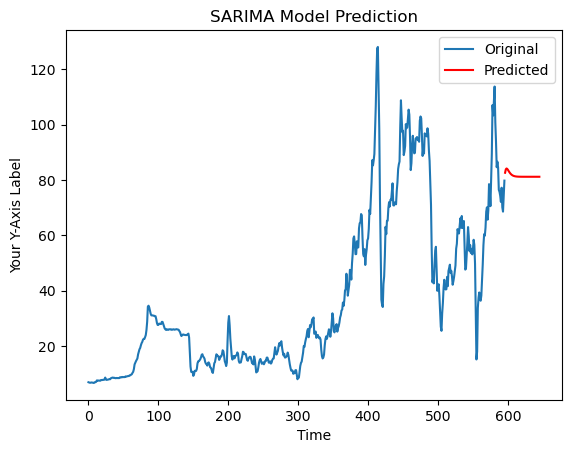

In [60]:
forecast = results.get_forecast(steps=50)

# Plot the original time series
plt.plot(oil_pp['Price'], label='Original')

# Plot the predicted values
plt.plot(forecast.predicted_mean, label='Predicted', color='red')

# Plot confidence intervals if needed
#plt.fill_between(forecast.conf_int()['lower'], forecast.conf_int()['upper'], color='pink', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Time')
plt.ylabel('Your Y-Axis Label')
plt.title('SARIMA Model Prediction')

# Show the plot
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  596
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1570.917
Date:                Sat, 02 Dec 2023   AIC                           3151.835
Time:                        13:41:58   BIC                           3173.778
Sample:                             0   HQIC                          3160.380
                                - 596                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3801      0.041     33.681      0.000       1.300       1.460
ar.L2         -0.4772      0.043    -11.061      0.000      -0.562      -0.393
ma.L1         -0.9211      0.053    -17.357      0.0

<Figure size 1000x600 with 0 Axes>

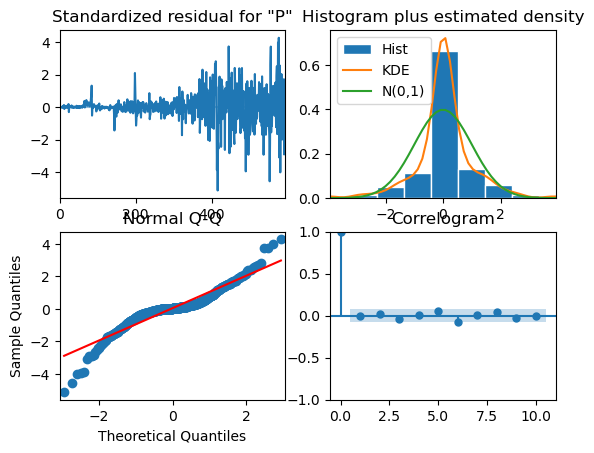

In [61]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'oil_pp' is your DataFrame and 'Price' is the column you want to model
oil_pp['Price'] = pd.to_numeric(oil_pp['Price'], errors='coerce')
oil_pp = oil_pp.dropna()  # or oil_pp = oil_pp.fillna(some_value)

# Fit the SARIMAX model
order = (2, 1, 2)  # Replace with your desired order (p, d, q)
seasonal_order = (0, 0, 0, 0)  # Replace with your desired seasonal order (P, D, Q, S)
model = sm.tsa.SARIMAX(oil_pp['Price'], order=order, seasonal_order=seasonal_order)
results = model.fit()

# Access the results and summary
print(results.summary())

# Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
results.plot_diagnostics(lags=10)  # You can adjust the 'lags' parameter based on your preference
plt.show()


In [62]:
import pickle
from pickle import load
from pickle import dump

In [63]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle

# Assuming 'oil_pp' is your DataFrame and 'Price' is the column you want to model
oil_pp['Price'] = pd.to_numeric(oil_pp['Price'], errors='coerce')
oil_pp = oil_pp.dropna()  # or oil_pp = oil_pp.fillna(some_value)

# Fit the SARIMAX model
#order = (2, 1, 2)  # Replace with your desired order (p, d, q)
#seasonal_order = (0, 0, 0, 0)  # Replace with your desired seasonal order (P, D, Q, S)
#model = sm.tsa.SARIMAX(oil_pp['Price'], order=order, seasonal_order=seasonal_order)
#results = model.fit()

# Save the results to a file
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)


# Access the loaded results and summary
#print(loaded_results.summary())

# Plot observed vs. predicted values
#plt.figure(figsize=(10, 6))
#loaded_results.plot_diagnostics(lags=10)  # You can adjust the 'lags' parameter based on your preference
plt.show()
